In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 200
beta = torch.linspace(0.04, 0.04, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0003, device='cuda:0')

In [3]:
alpha_

tensor([9.6000e-01, 9.2160e-01, 8.8474e-01, 8.4935e-01, 8.1537e-01, 7.8276e-01,
        7.5145e-01, 7.2139e-01, 6.9253e-01, 6.6483e-01, 6.3824e-01, 6.1271e-01,
        5.8820e-01, 5.6467e-01, 5.4209e-01, 5.2040e-01, 4.9959e-01, 4.7960e-01,
        4.6042e-01, 4.4200e-01, 4.2432e-01, 4.0735e-01, 3.9106e-01, 3.7541e-01,
        3.6040e-01, 3.4598e-01, 3.3214e-01, 3.1886e-01, 3.0610e-01, 2.9386e-01,
        2.8210e-01, 2.7082e-01, 2.5999e-01, 2.4959e-01, 2.3960e-01, 2.3002e-01,
        2.2082e-01, 2.1199e-01, 2.0351e-01, 1.9537e-01, 1.8755e-01, 1.8005e-01,
        1.7285e-01, 1.6593e-01, 1.5930e-01, 1.5292e-01, 1.4681e-01, 1.4094e-01,
        1.3530e-01, 1.2989e-01, 1.2469e-01, 1.1970e-01, 1.1491e-01, 1.1032e-01,
        1.0591e-01, 1.0167e-01, 9.7602e-02, 9.3698e-02, 8.9950e-02, 8.6352e-02,
        8.2898e-02, 7.9582e-02, 7.6399e-02, 7.3343e-02, 7.0409e-02, 6.7593e-02,
        6.4889e-02, 6.2294e-02, 5.9802e-02, 5.7410e-02, 5.5113e-02, 5.2909e-02,
        5.0793e-02, 4.8761e-02, 4.6810e-

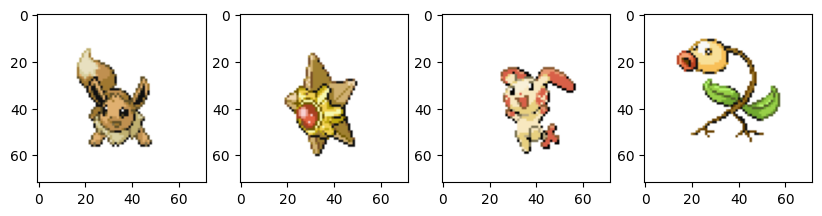

In [4]:
pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.1),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.1),
    v2.RandomGrayscale(p = 0.1),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([pos_transform(col_transform(x)) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
model = UNet_conditional(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Dark"], ["Fairy"], ["Electric"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[1, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    c = isigmoid(c)

    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

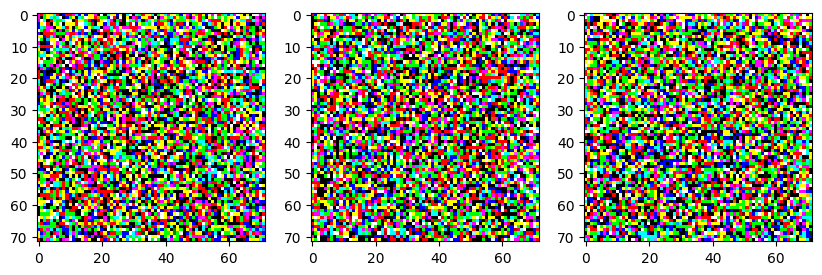

0.04862732:   1%|          | 999/100001 [01:36<2:36:19, 10.55it/s]

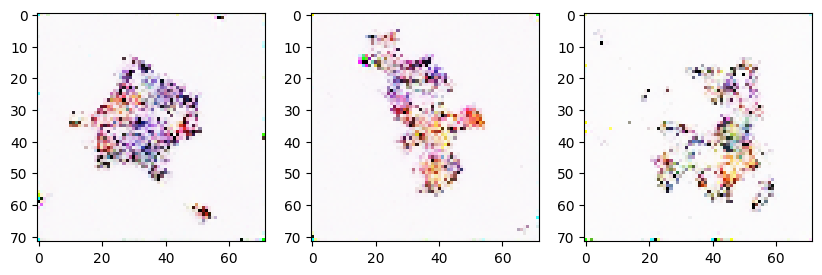

0.03442338:   2%|▏         | 1999/100001 [03:12<2:34:52, 10.55it/s] 

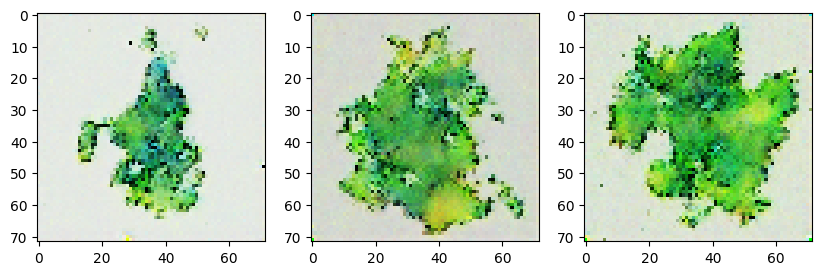

0.02636845:   3%|▎         | 2999/100001 [04:49<2:32:33, 10.60it/s] 

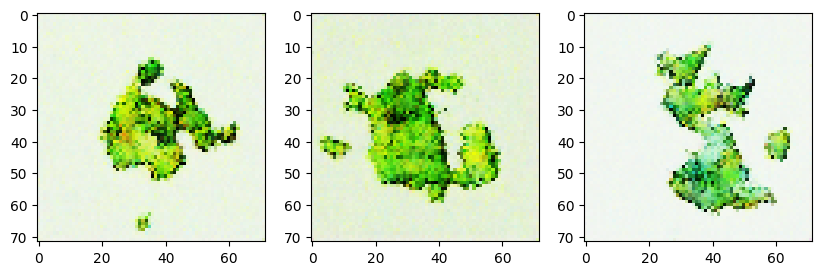

0.03988953:   4%|▍         | 3999/100001 [06:25<2:30:56, 10.60it/s] 

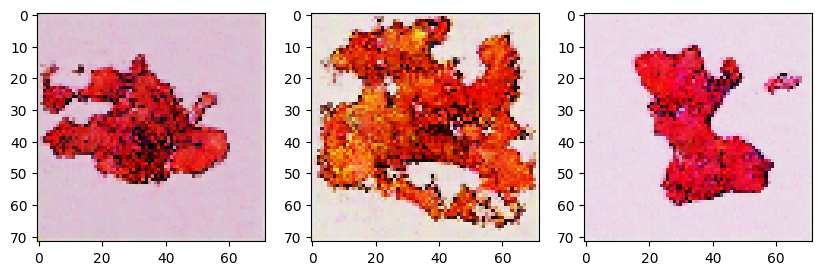

0.02588517:   5%|▍         | 4999/100001 [08:01<2:29:28, 10.59it/s]

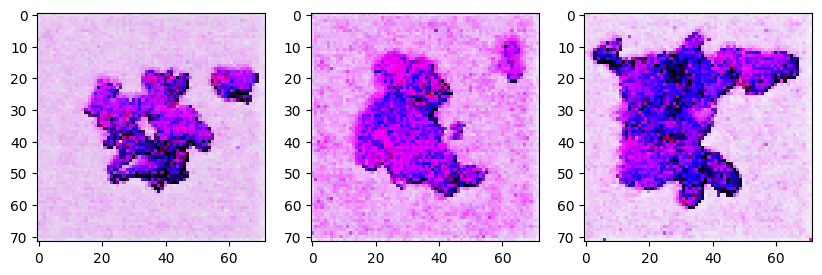

0.03290520:   6%|▌         | 5999/100001 [09:38<2:27:30, 10.62it/s]

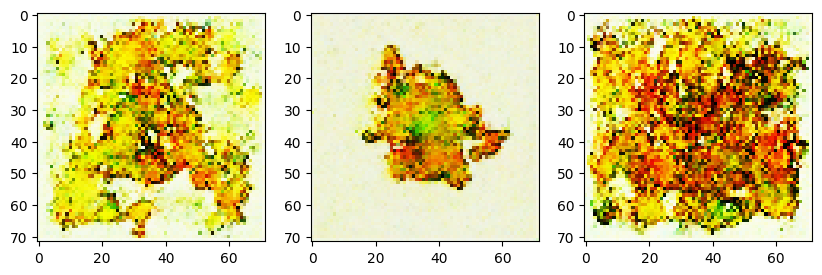

0.02973096:   7%|▋         | 6999/100001 [11:14<2:26:15, 10.60it/s]

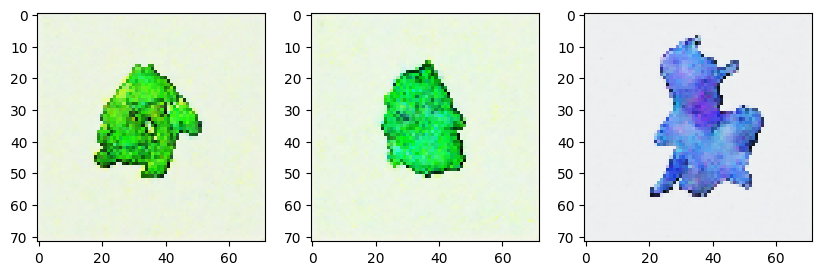

0.02543795:   8%|▊         | 7999/100001 [12:50<2:24:58, 10.58it/s]

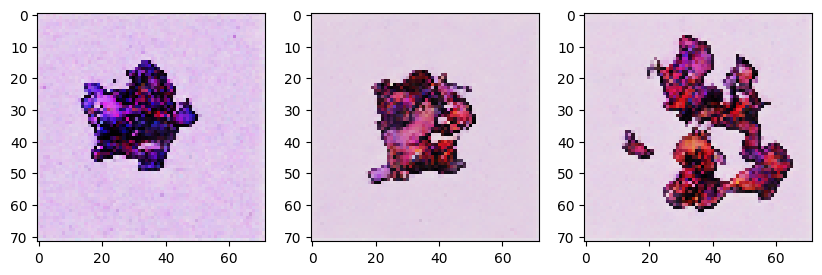

0.01555574:   9%|▉         | 8999/100001 [14:27<2:23:13, 10.59it/s]

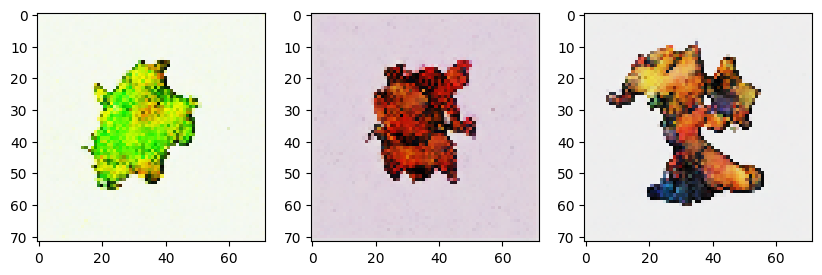

0.01379388:  10%|▉         | 9999/100001 [16:03<2:21:40, 10.59it/s]

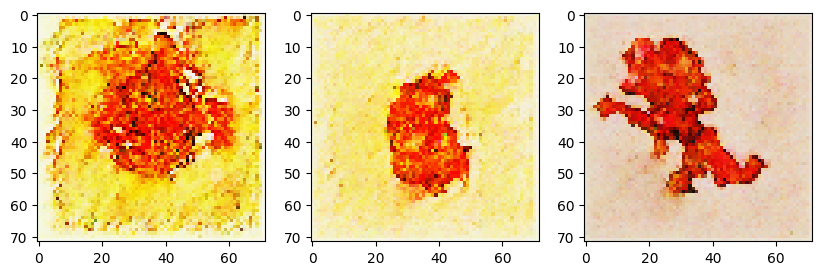

0.01466705:  11%|█         | 10999/100001 [17:39<2:20:05, 10.59it/s]

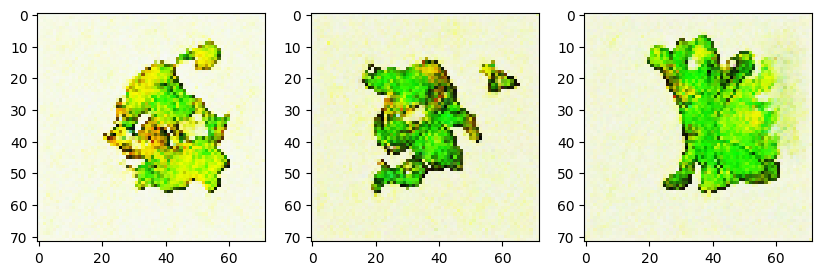

0.02012298:  12%|█▏        | 11999/100001 [19:16<2:18:15, 10.61it/s]

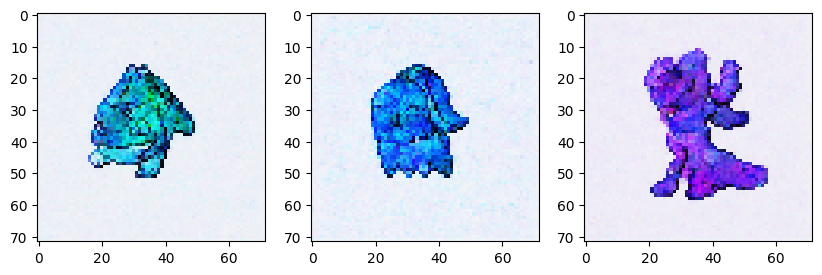

0.01930442:  13%|█▎        | 12999/100001 [20:52<2:16:57, 10.59it/s]

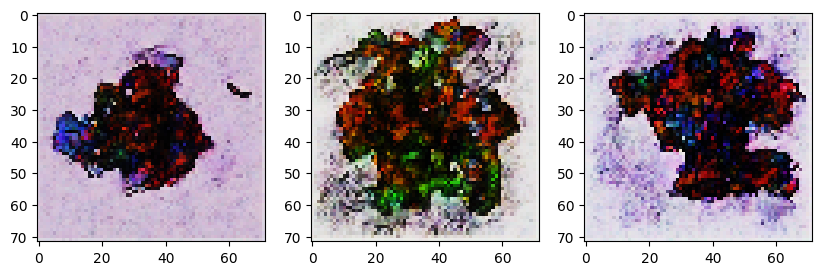

0.01977785:  14%|█▍        | 13999/100001 [22:28<2:15:17, 10.59it/s]

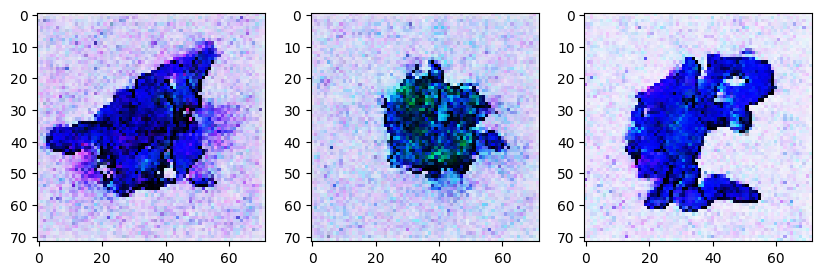

0.02194456:  15%|█▍        | 14999/100001 [24:05<2:13:39, 10.60it/s]

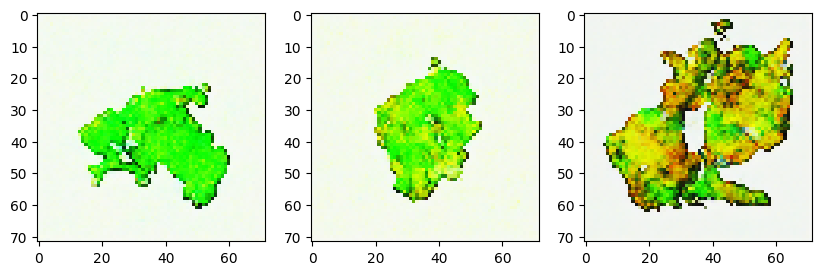

0.01311464:  16%|█▌        | 15999/100001 [25:41<2:12:14, 10.59it/s]

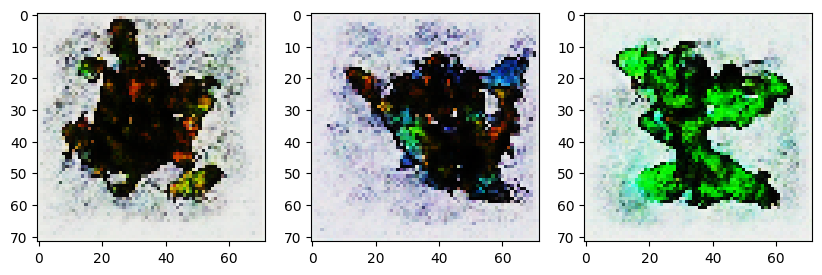

0.01253021:  17%|█▋        | 16999/100001 [27:17<2:10:25, 10.61it/s]

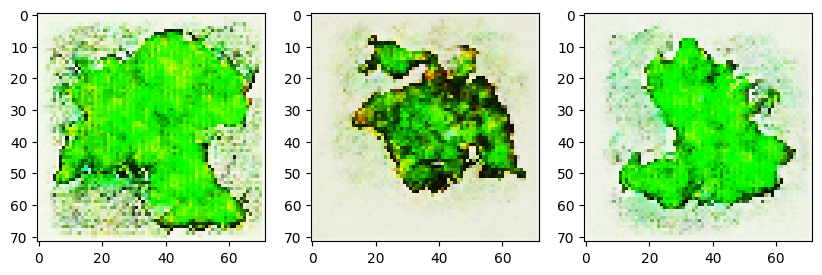

0.02006016:  18%|█▊        | 17999/100001 [28:54<2:09:01, 10.59it/s]

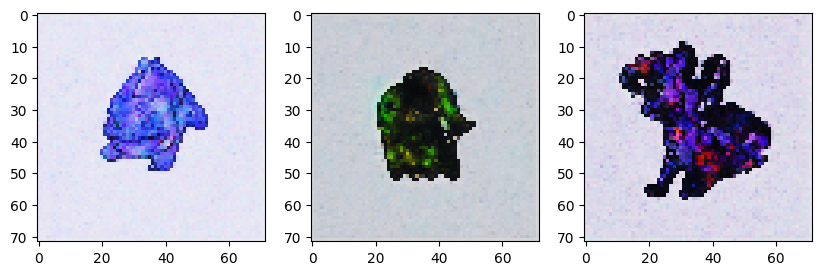

0.01726144:  19%|█▉        | 18999/100001 [30:30<2:07:29, 10.59it/s]

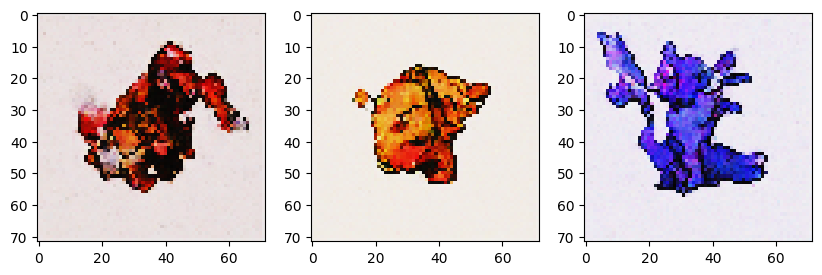

0.02239247:  20%|█▉        | 19999/100001 [32:06<2:06:05, 10.57it/s]

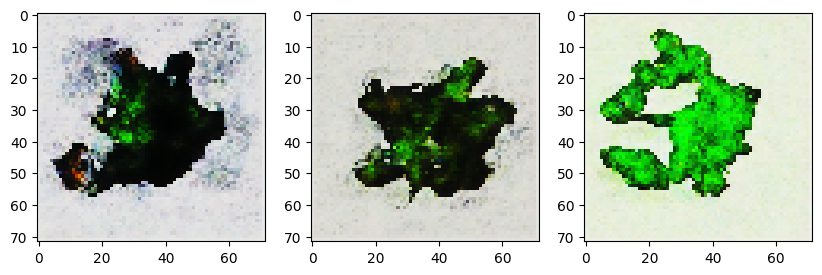

0.00735967:  21%|██        | 20999/100001 [33:43<2:04:17, 10.59it/s]

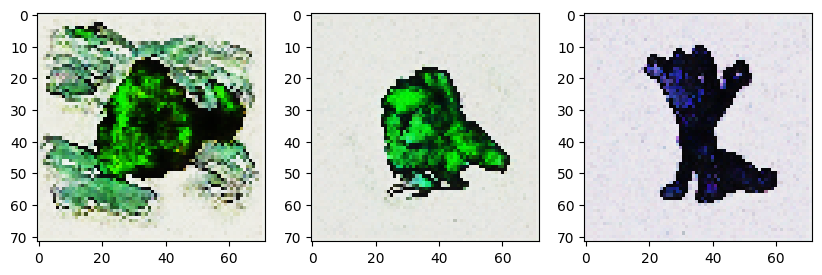

0.01062670:  22%|██▏       | 21999/100001 [35:19<2:02:45, 10.59it/s]

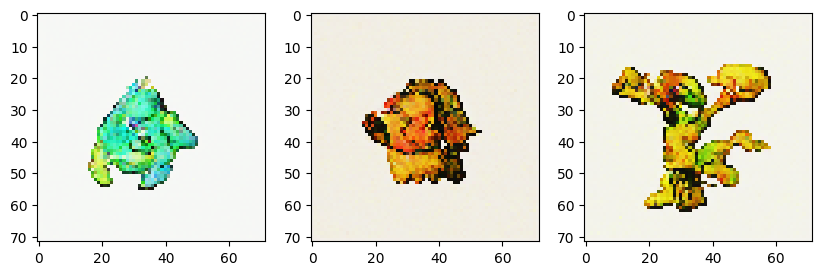

0.01073784:  23%|██▎       | 22999/100001 [36:55<2:01:13, 10.59it/s]

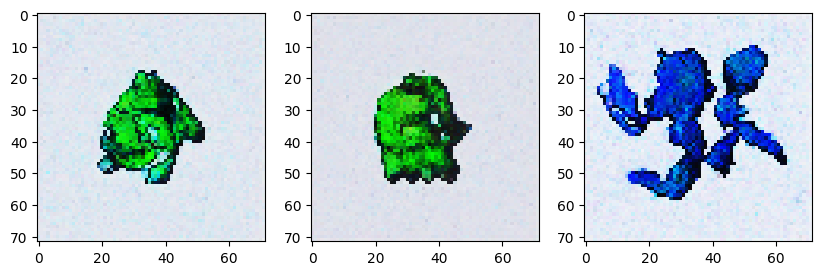

0.03802349:  24%|██▍       | 23999/100001 [38:32<1:59:39, 10.59it/s]

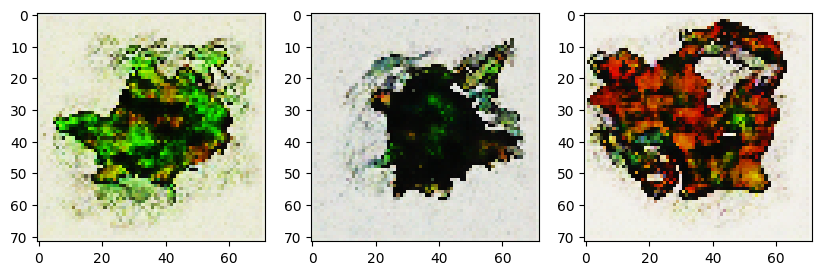

0.00893645:  25%|██▍       | 24999/100001 [40:08<1:58:06, 10.58it/s]

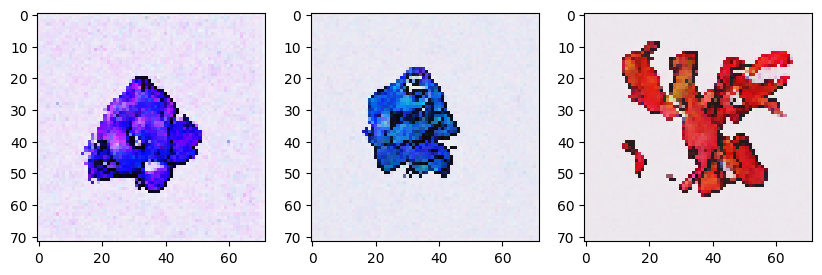

0.02294204:  26%|██▌       | 25999/100001 [41:44<1:56:26, 10.59it/s]

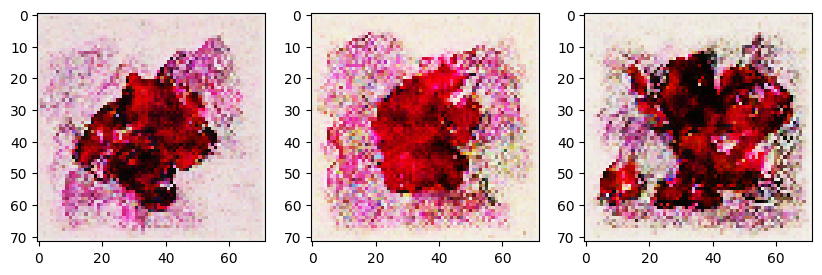

0.01416165:  27%|██▋       | 26999/100001 [43:21<1:54:56, 10.59it/s]

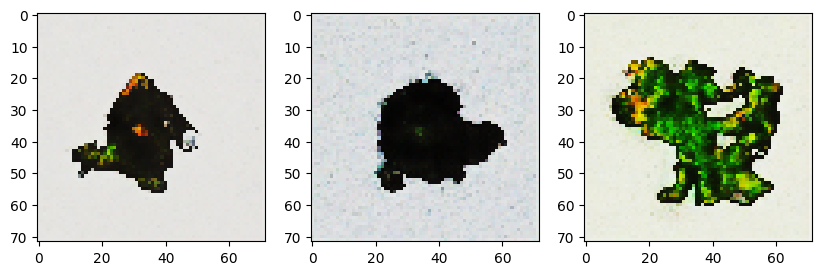

0.01278366:  28%|██▊       | 27999/100001 [44:57<1:53:26, 10.58it/s]

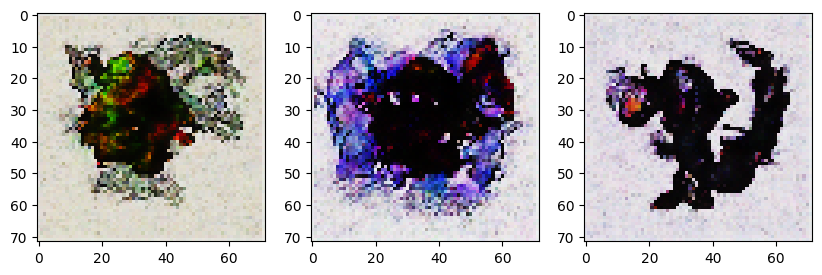

0.01205116:  29%|██▉       | 28999/100001 [46:33<1:51:39, 10.60it/s]

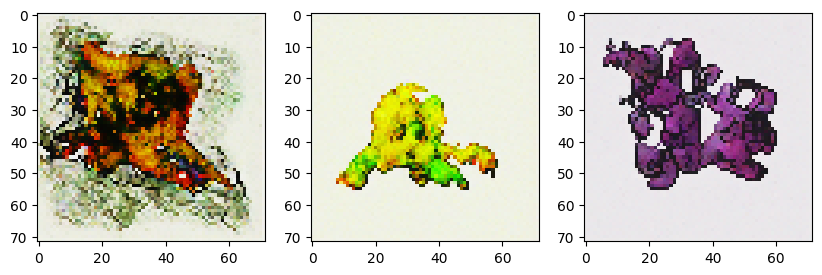

0.01333331:  30%|██▉       | 29999/100001 [48:10<1:50:15, 10.58it/s]

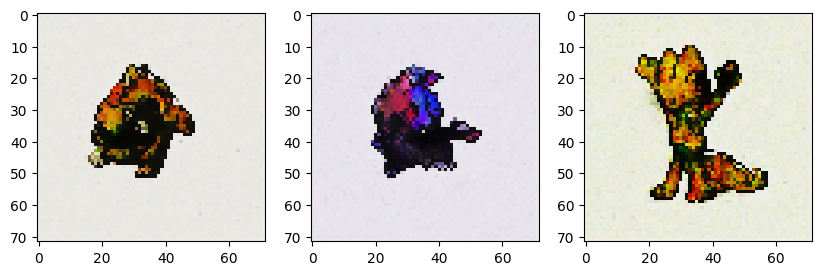

0.01118396:  31%|███       | 30999/100001 [49:46<1:48:44, 10.58it/s]

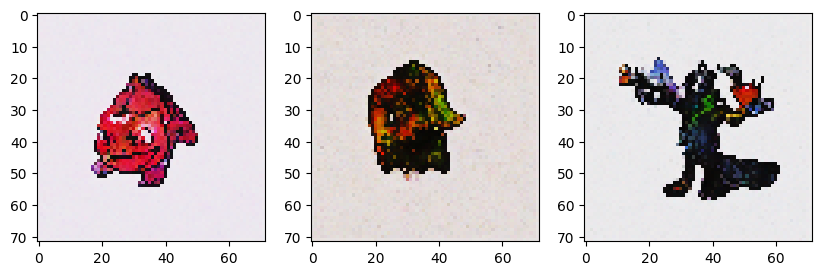

0.01441954:  32%|███▏      | 31999/100001 [51:23<1:47:17, 10.56it/s]

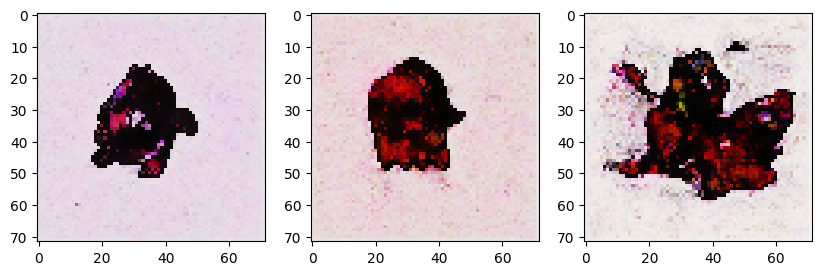

0.01188821:  33%|███▎      | 32999/100001 [52:59<1:45:29, 10.59it/s]

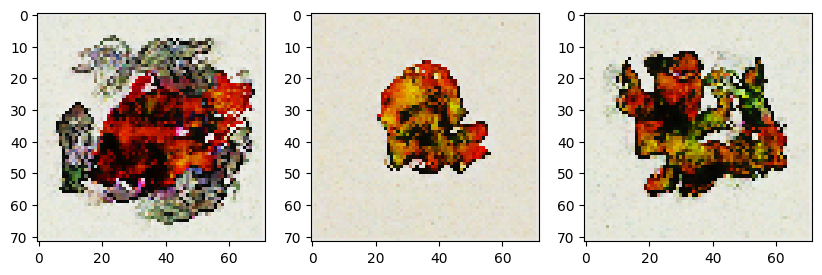

0.02093445:  34%|███▍      | 33999/100001 [54:35<1:44:00, 10.58it/s]

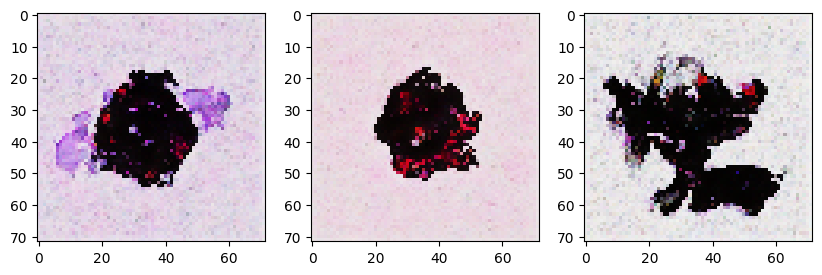

0.02203150:  35%|███▍      | 34999/100001 [56:12<1:42:26, 10.58it/s]

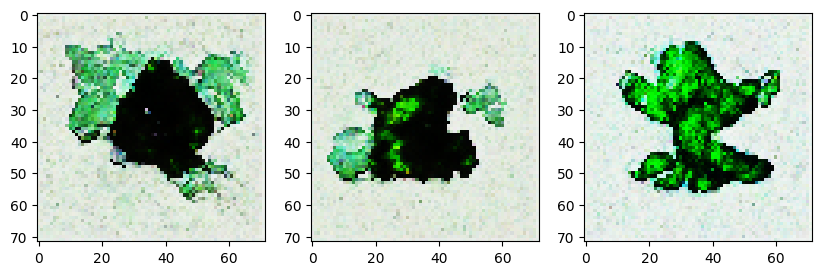

0.01850051:  36%|███▌      | 35999/100001 [57:48<1:40:53, 10.57it/s]

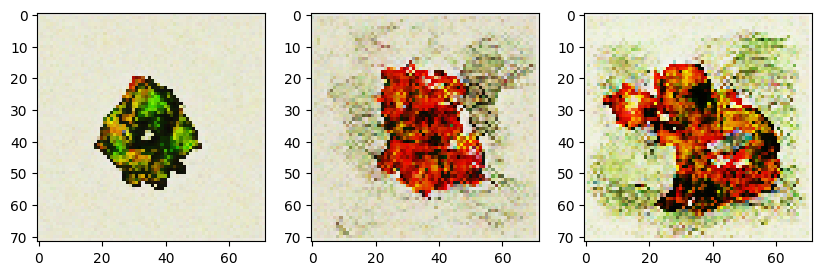

0.01310487:  37%|███▋      | 36999/100001 [59:24<1:39:14, 10.58it/s]

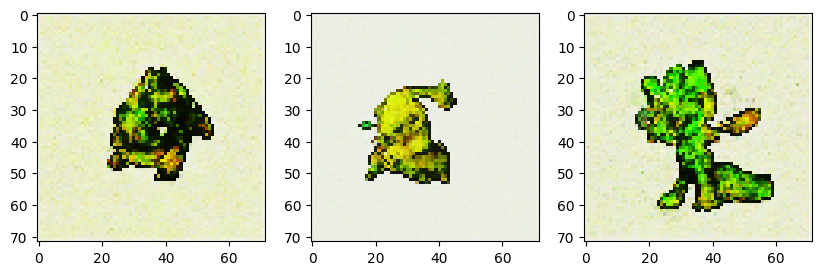

0.00957113:  38%|███▊      | 37999/100001 [1:01:01<1:37:41, 10.58it/s]

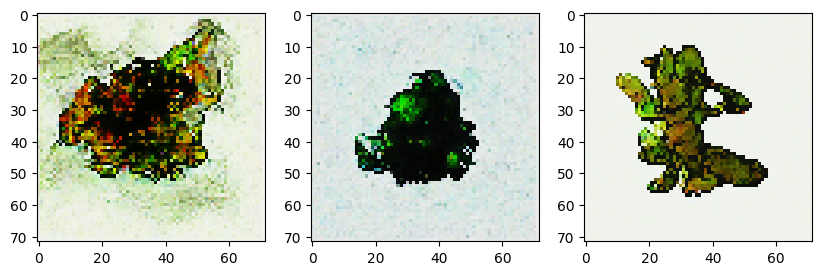

0.01674456:  39%|███▉      | 38999/100001 [1:02:37<1:36:04, 10.58it/s]

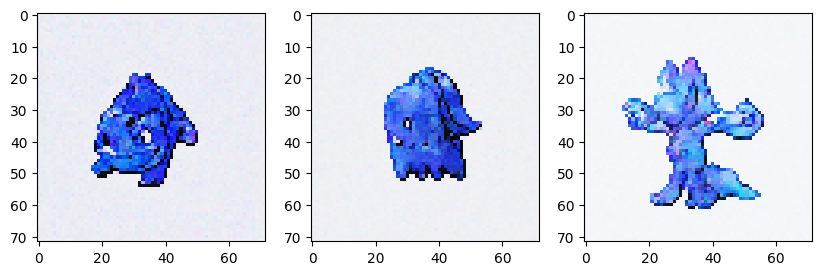

0.00899552:  40%|███▉      | 39999/100001 [1:04:14<1:34:30, 10.58it/s]

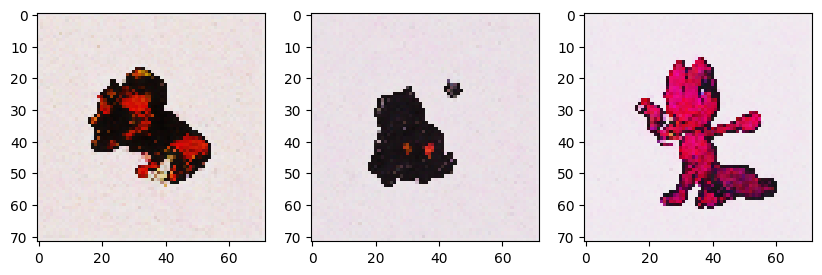

0.00753798:  41%|████      | 40999/100001 [1:05:50<1:33:04, 10.57it/s]

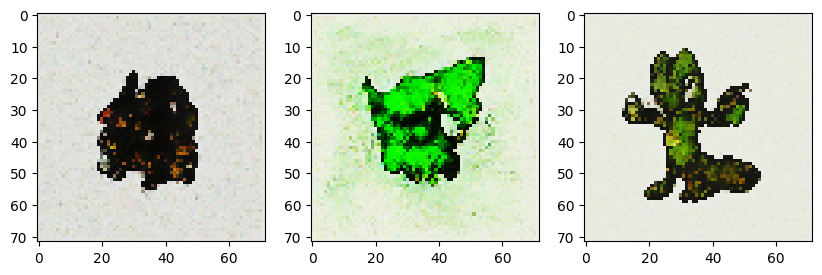

0.01478697:  42%|████▏     | 41999/100001 [1:07:26<1:31:19, 10.58it/s]

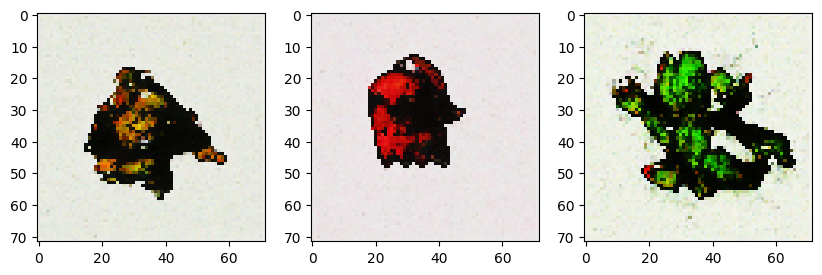

0.01199489:  43%|████▎     | 42999/100001 [1:09:03<1:29:49, 10.58it/s]

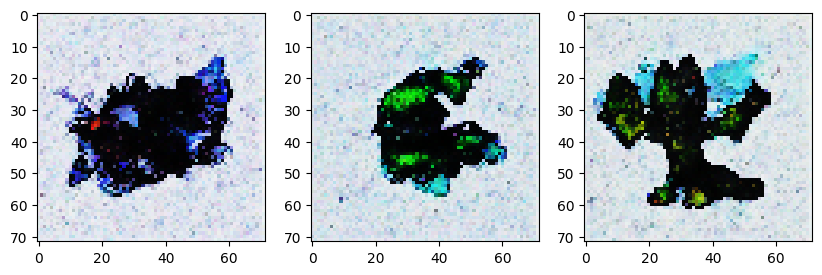

0.01836440:  44%|████▍     | 43999/100001 [1:10:39<1:28:11, 10.58it/s]

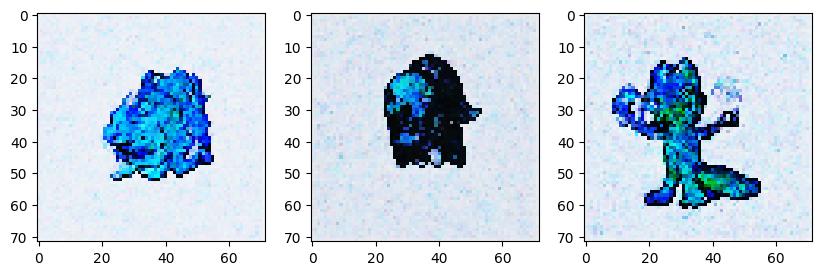

0.01197336:  45%|████▍     | 44999/100001 [1:12:15<1:26:36, 10.58it/s]

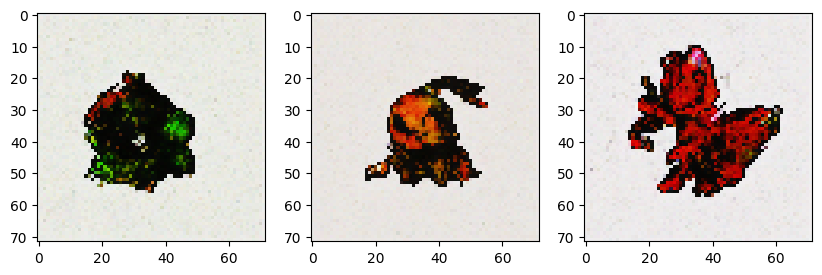

0.01005736:  46%|████▌     | 45999/100001 [1:13:52<1:24:51, 10.61it/s]

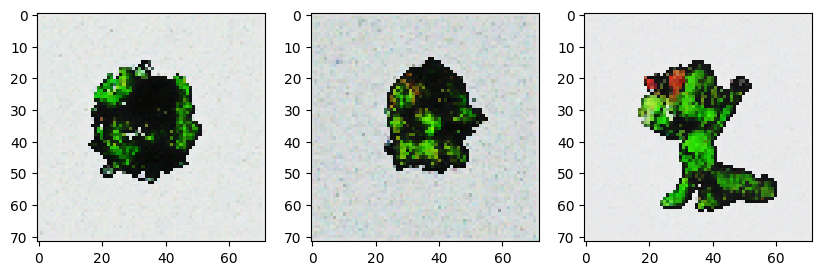

0.01490349:  47%|████▋     | 46999/100001 [1:15:28<1:23:25, 10.59it/s]

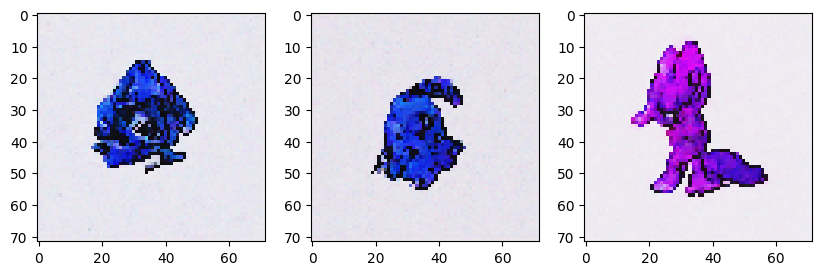

0.01901194:  48%|████▊     | 47999/100001 [1:17:05<1:21:56, 10.58it/s]

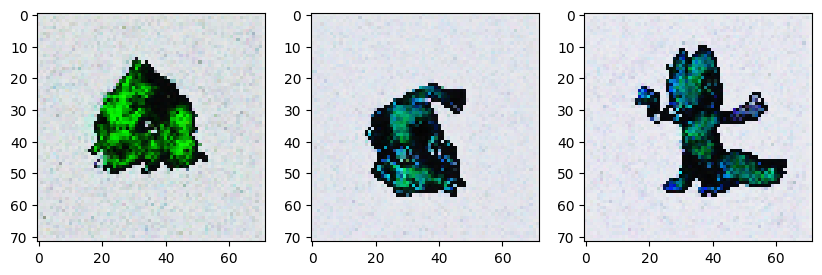

0.01804986:  49%|████▉     | 48999/100001 [1:18:41<1:20:21, 10.58it/s]

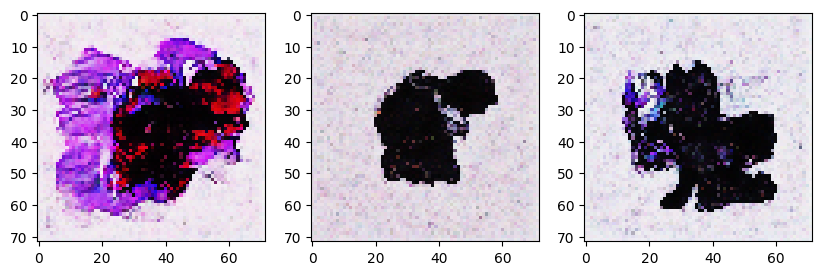

0.01069496:  50%|████▉     | 49999/100001 [1:20:17<1:18:44, 10.58it/s]

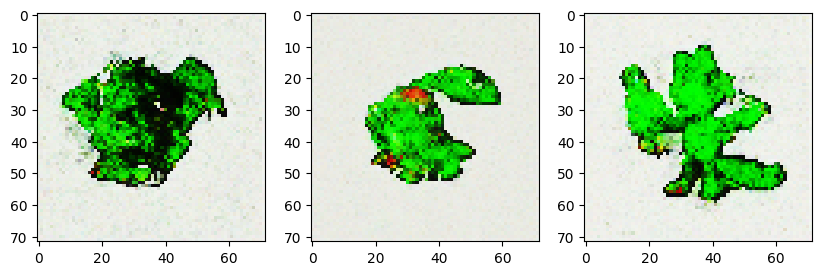

0.00984977:  51%|█████     | 50999/100001 [1:21:54<1:17:13, 10.58it/s]

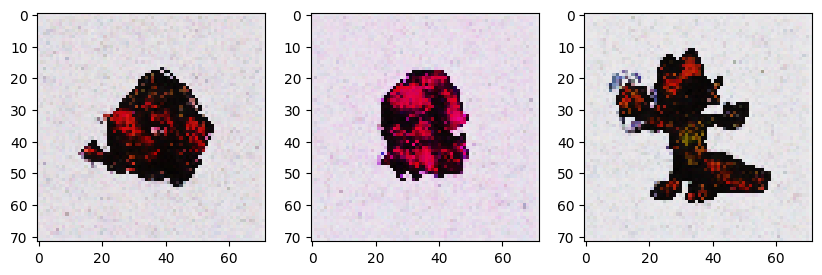

0.00874411:  52%|█████▏    | 51999/100001 [1:23:30<1:15:37, 10.58it/s]

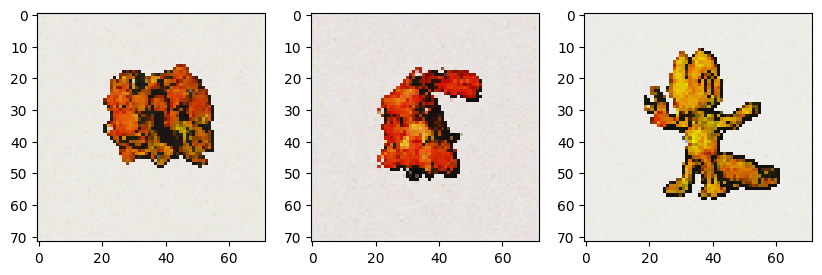

0.01307124:  53%|█████▎    | 52999/100001 [1:25:07<1:14:00, 10.58it/s]

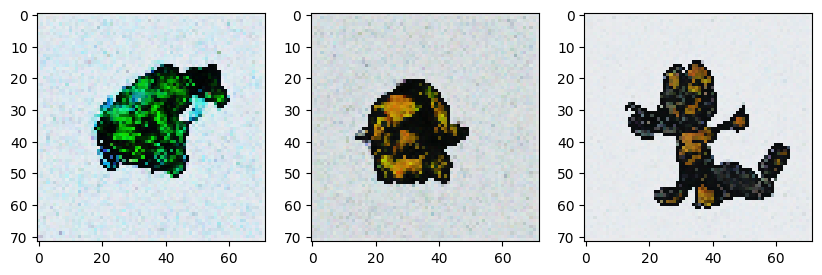

0.01181075:  54%|█████▍    | 53999/100001 [1:26:43<1:12:25, 10.58it/s]

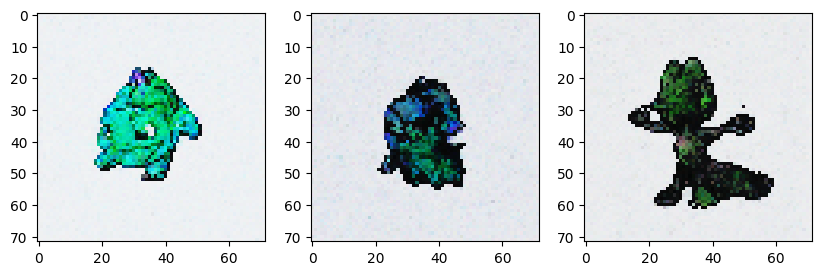

0.01459922:  55%|█████▍    | 54999/100001 [1:28:19<1:10:53, 10.58it/s]

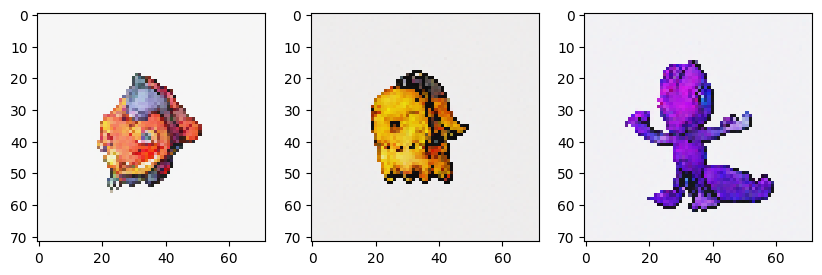

0.01317054:  56%|█████▌    | 55999/100001 [1:29:56<1:09:18, 10.58it/s]

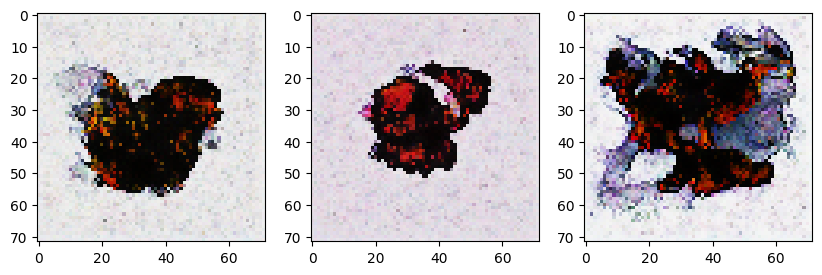

0.01871249:  57%|█████▋    | 56999/100001 [1:31:32<1:07:41, 10.59it/s]

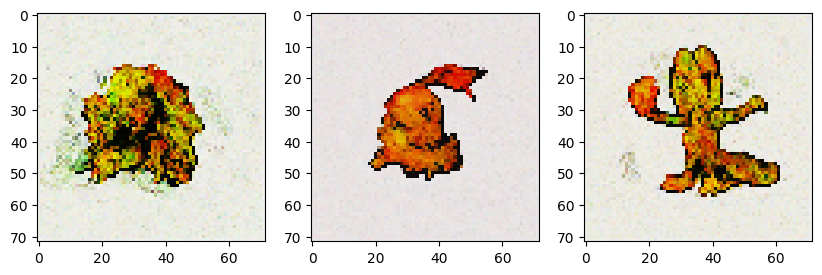

0.01272750:  58%|█████▊    | 57999/100001 [1:33:08<1:06:07, 10.59it/s]

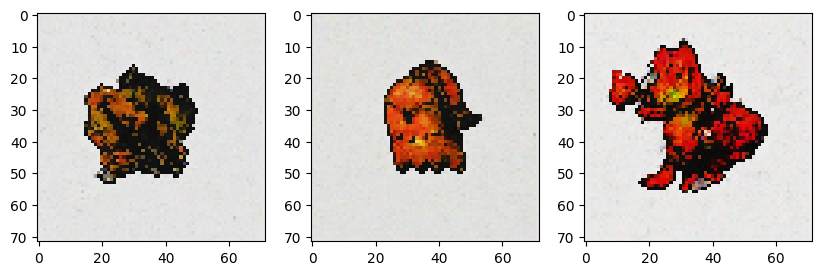

0.01232013:  59%|█████▉    | 58999/100001 [1:34:45<1:04:36, 10.58it/s]

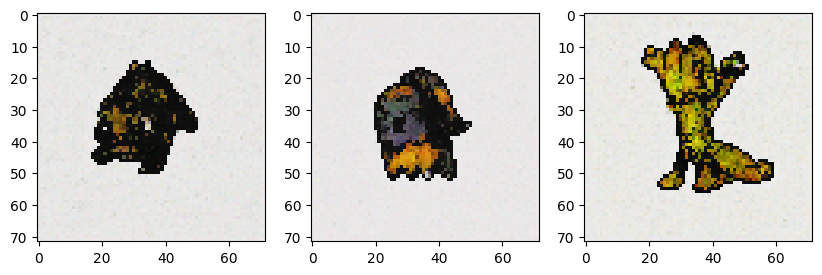

0.02003842:  60%|█████▉    | 59999/100001 [1:36:21<1:02:57, 10.59it/s]

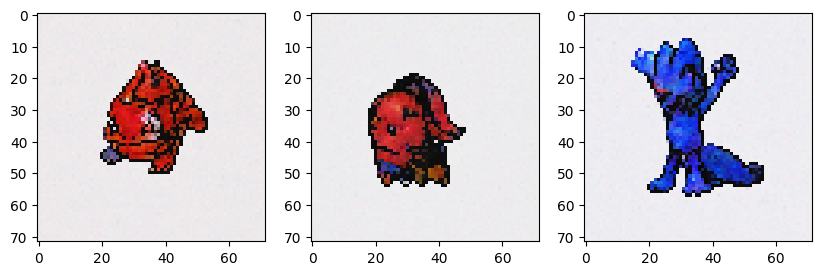

0.00663432:  61%|██████    | 60999/100001 [1:37:57<1:01:23, 10.59it/s]

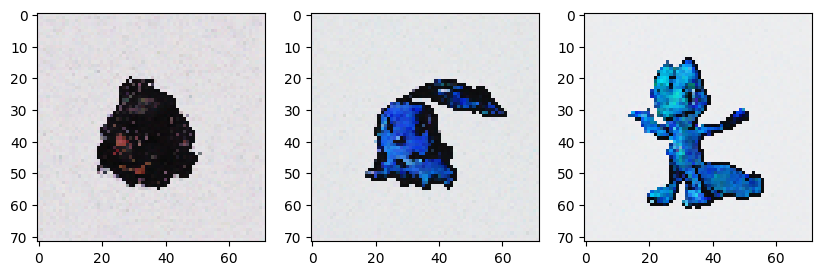

0.01592054:  62%|██████▏   | 61999/100001 [1:39:34<59:54, 10.57it/s]  

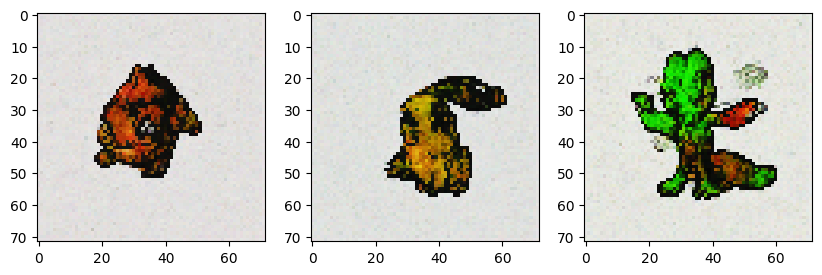

0.00702692:  63%|██████▎   | 62999/100001 [1:41:10<58:18, 10.58it/s]  

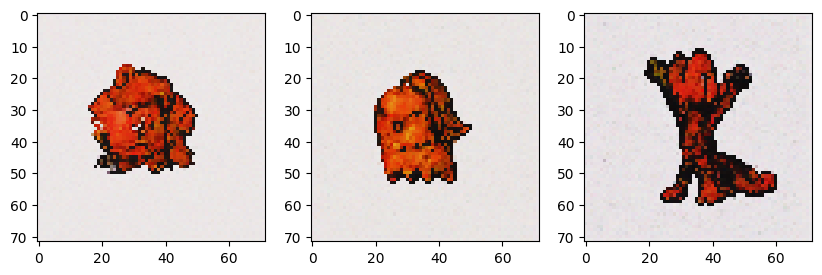

0.01873018:  64%|██████▍   | 63999/100001 [1:42:47<56:40, 10.59it/s]  

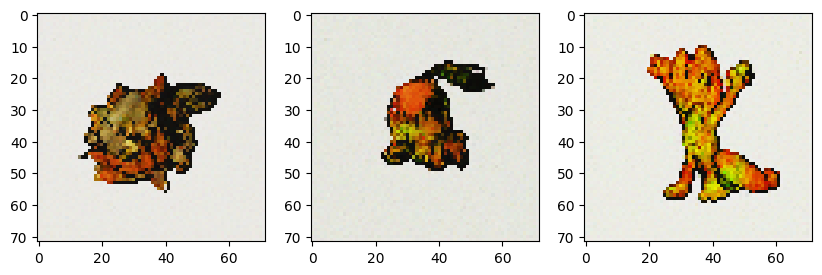

0.00998977:  65%|██████▍   | 64999/100001 [1:44:23<55:08, 10.58it/s]  

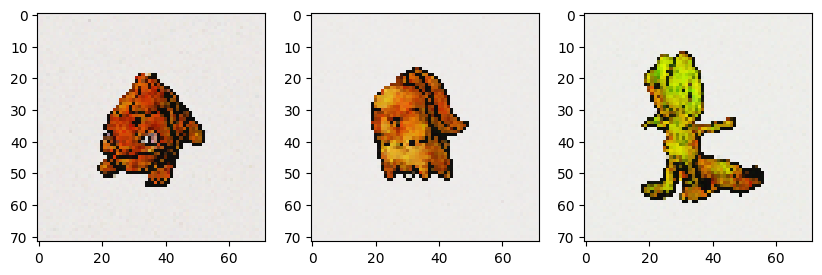

0.01676616:  66%|██████▌   | 65999/100001 [1:45:59<53:32, 10.59it/s]  

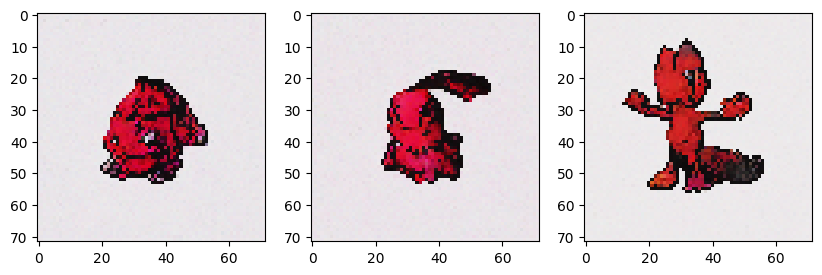

0.00907273:  67%|██████▋   | 66999/100001 [1:47:36<52:01, 10.57it/s]  

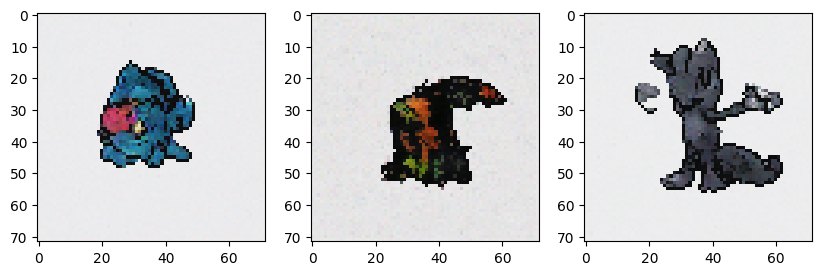

0.01923873:  68%|██████▊   | 67999/100001 [1:49:12<50:26, 10.57it/s]  

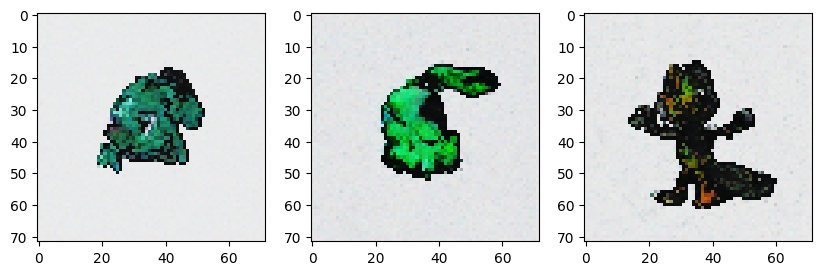

0.01242485:  69%|██████▉   | 68999/100001 [1:50:49<48:50, 10.58it/s]  

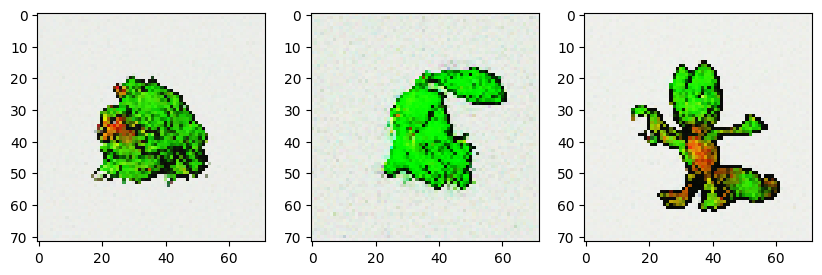

0.01210386:  70%|██████▉   | 69999/100001 [1:52:25<47:18, 10.57it/s]  

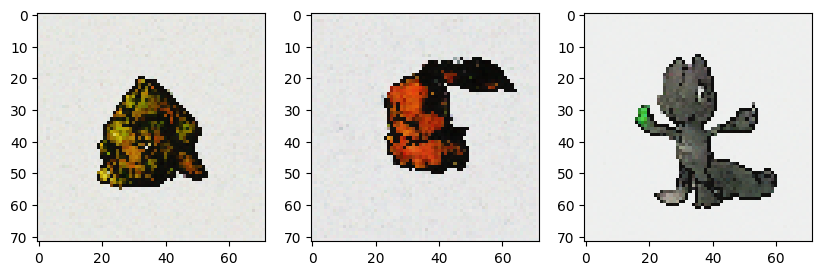

0.01626786:  71%|███████   | 71000/100001 [1:54:01<45:36, 10.60it/s]  

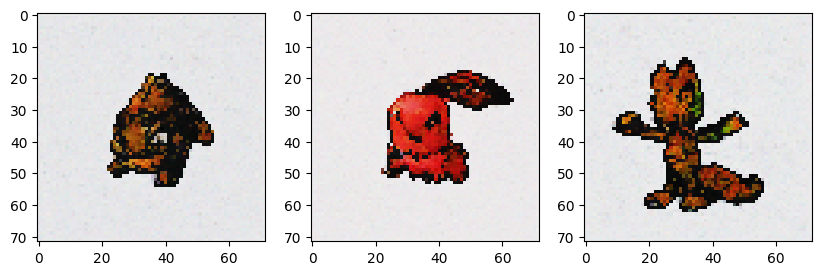

0.00693311:  72%|███████▏  | 72000/100001 [1:55:38<44:03, 10.59it/s]  

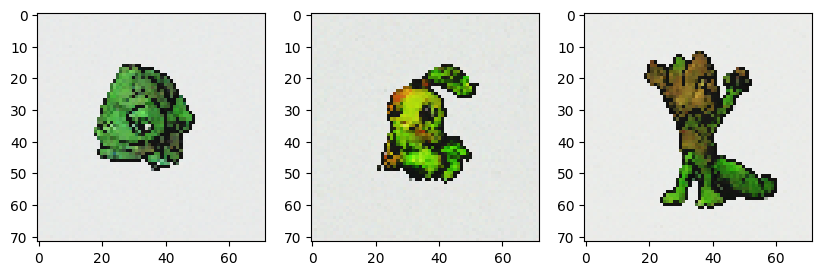

0.01498801:  73%|███████▎  | 73000/100001 [1:57:14<42:28, 10.59it/s]  

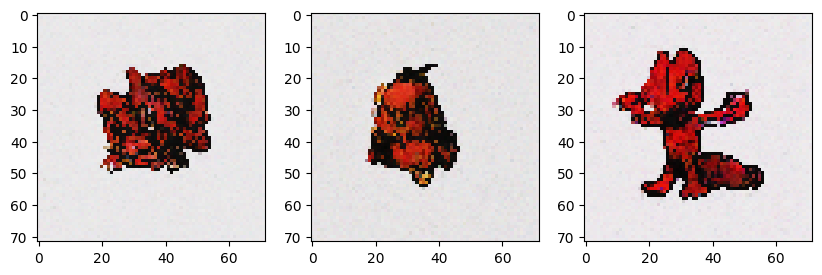

0.01199976:  74%|███████▍  | 74000/100001 [1:58:50<41:03, 10.56it/s]  

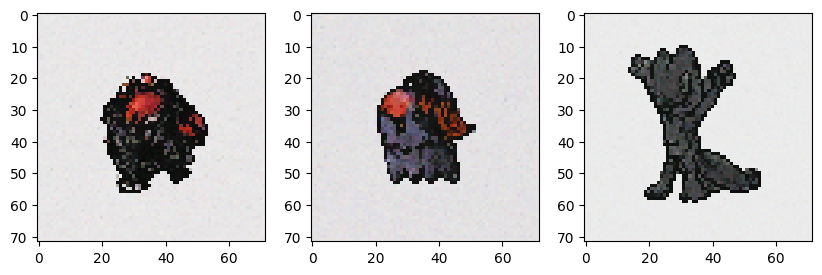

0.00319595:  75%|███████▍  | 75000/100001 [2:00:27<39:25, 10.57it/s]  

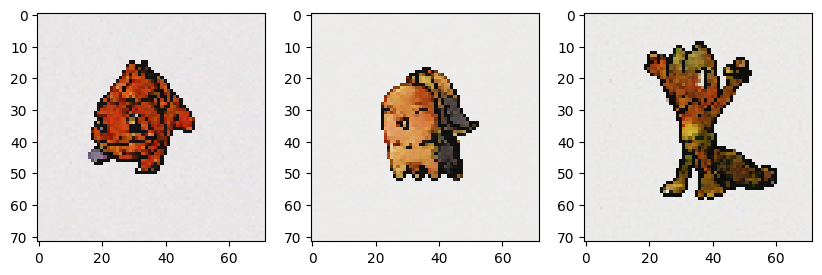

0.01469376:  76%|███████▌  | 76000/100001 [2:02:03<37:48, 10.58it/s]  

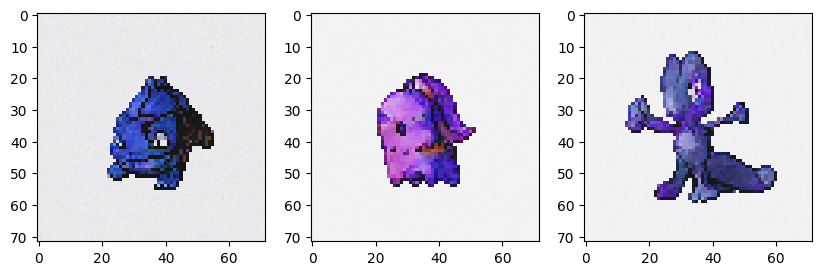

0.01004544:  77%|███████▋  | 77000/100001 [2:03:40<36:15, 10.57it/s]  

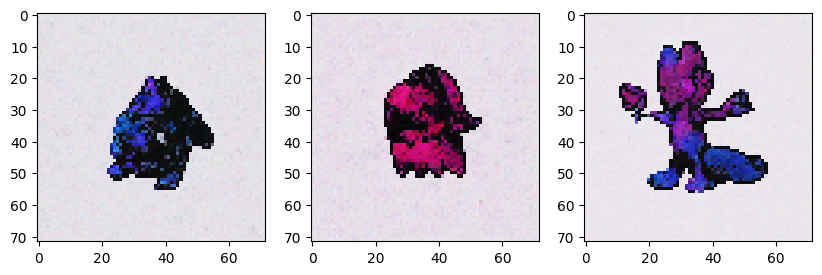

0.01415013:  78%|███████▊  | 78000/100001 [2:05:16<34:40, 10.57it/s]  

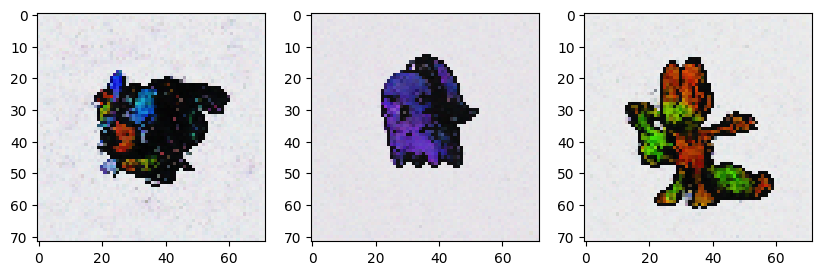

0.01070728:  79%|███████▉  | 79000/100001 [2:06:52<33:04, 10.58it/s]  

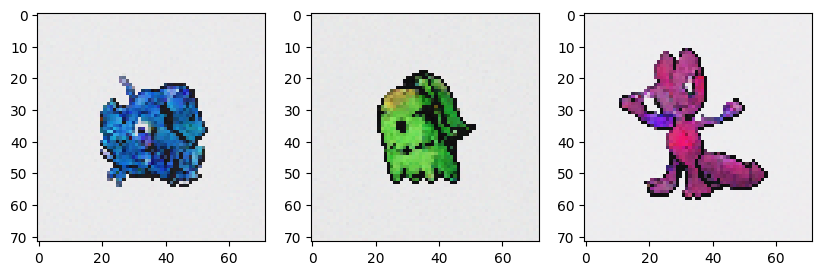

0.01356440:  80%|███████▉  | 80000/100001 [2:08:29<31:28, 10.59it/s]  

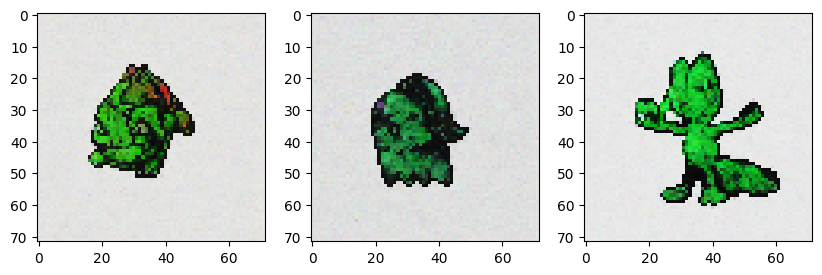

0.01167216:  81%|████████  | 81000/100001 [2:10:05<29:59, 10.56it/s]  

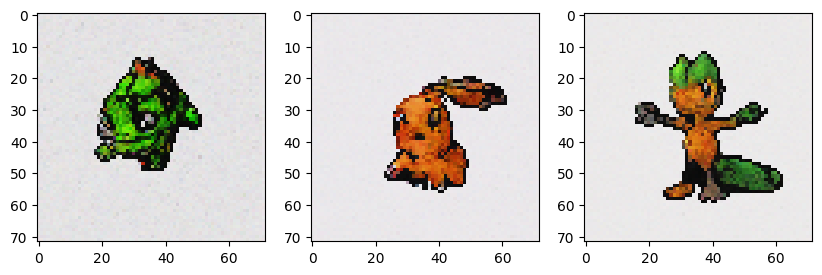

0.00553054:  82%|████████▏ | 82000/100001 [2:11:42<28:21, 10.58it/s]  

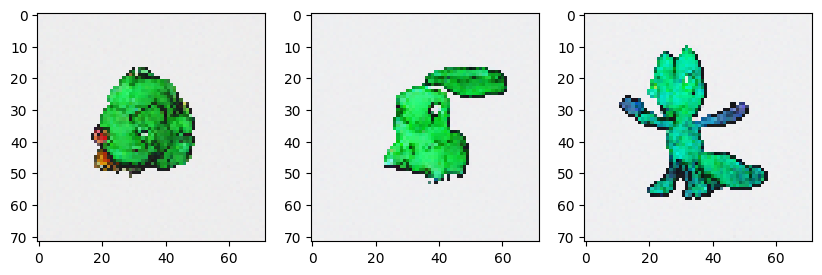

0.01364202:  83%|████████▎ | 83000/100001 [2:13:18<26:46, 10.58it/s]  

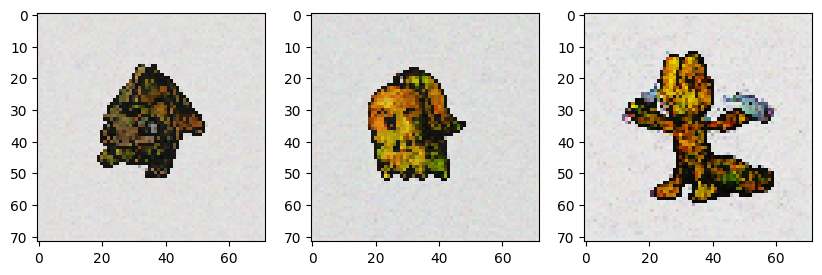

0.02080613:  84%|████████▍ | 84000/100001 [2:14:54<25:11, 10.58it/s]  

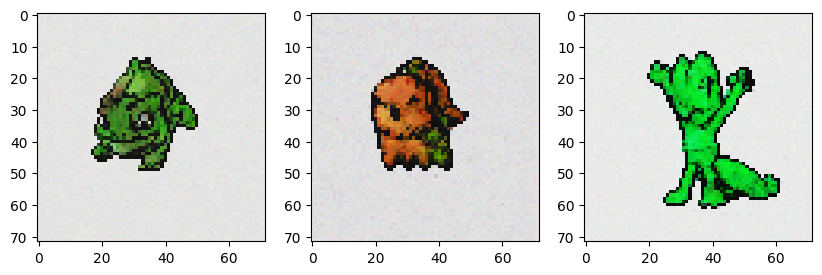

0.01070876:  85%|████████▍ | 85000/100001 [2:16:31<23:38, 10.58it/s]  

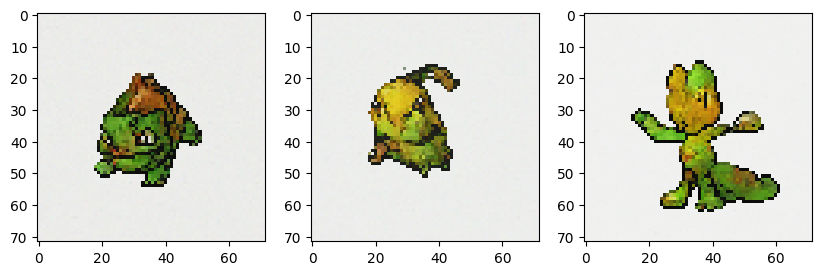

0.01277932:  86%|████████▌ | 86000/100001 [2:18:07<22:03, 10.58it/s]  

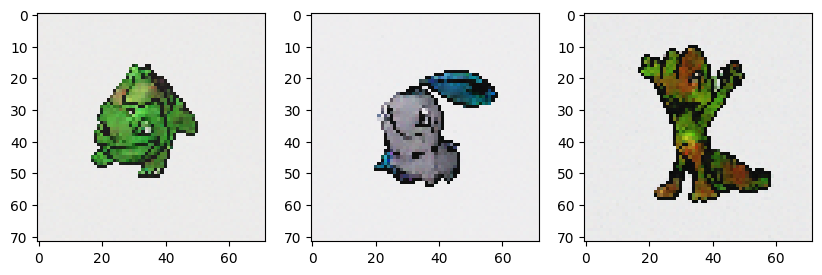

0.00570797:  87%|████████▋ | 87000/100001 [2:19:43<20:27, 10.59it/s]  

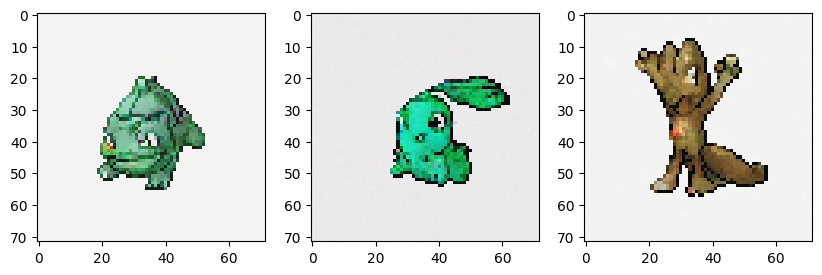

0.01306639:  88%|████████▊ | 88000/100001 [2:21:20<18:54, 10.58it/s]  

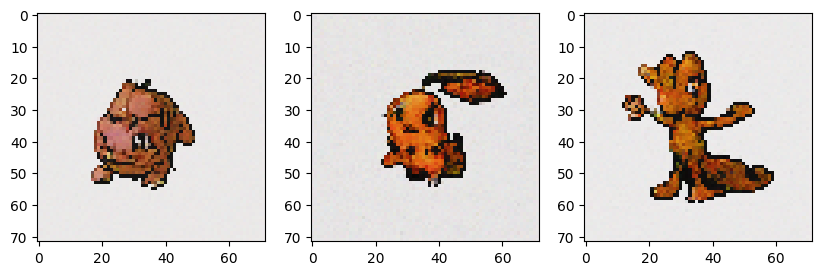

0.01195290:  89%|████████▉ | 89000/100001 [2:22:56<17:20, 10.58it/s]  

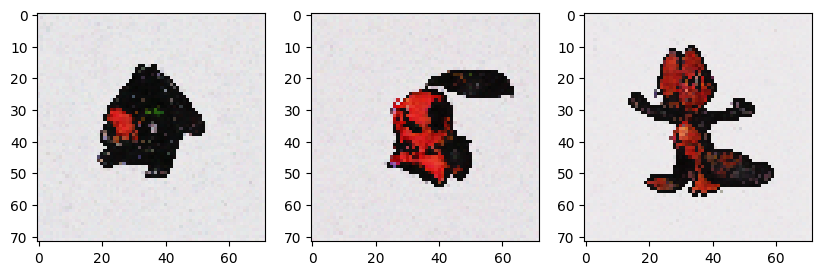

0.02288393:  90%|████████▉ | 90000/100001 [2:24:33<15:45, 10.58it/s]  

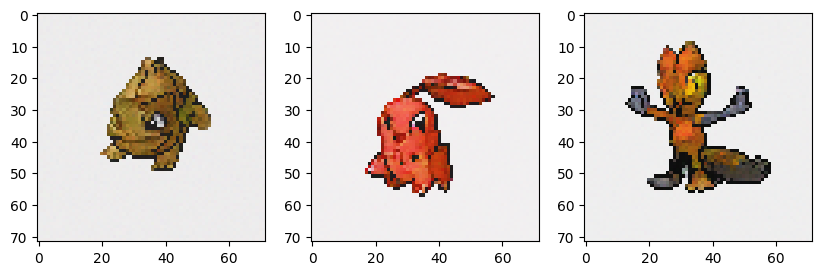

0.00586802:  91%|█████████ | 91000/100001 [2:26:09<14:10, 10.58it/s]  

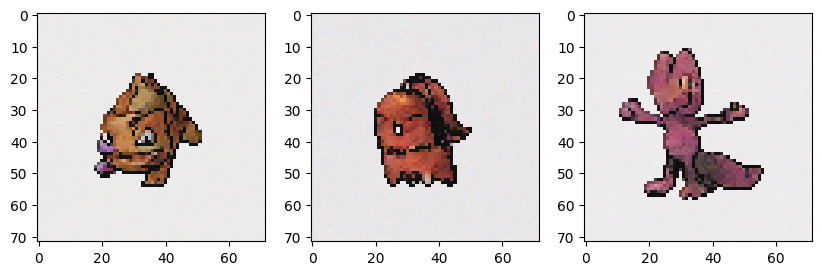

0.00698199:  92%|█████████▏| 92000/100001 [2:27:45<12:37, 10.57it/s]

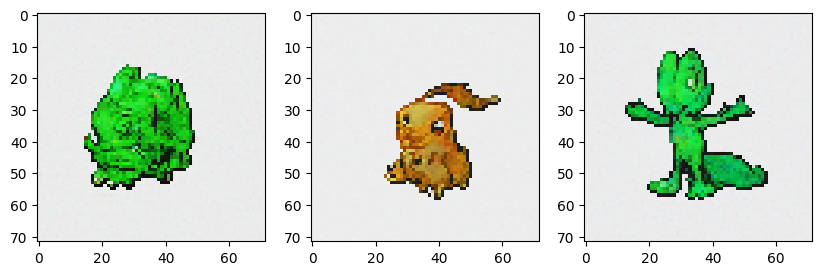

0.01408126:  93%|█████████▎| 93000/100001 [2:29:22<11:01, 10.58it/s]

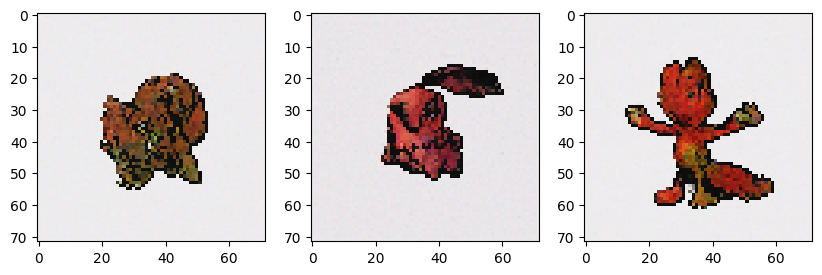

0.00914590:  94%|█████████▍| 94000/100001 [2:30:58<09:27, 10.57it/s]

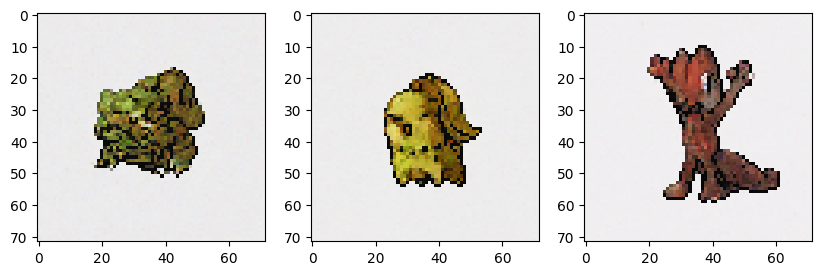

0.00824180:  95%|█████████▍| 95000/100001 [2:32:35<07:52, 10.59it/s]

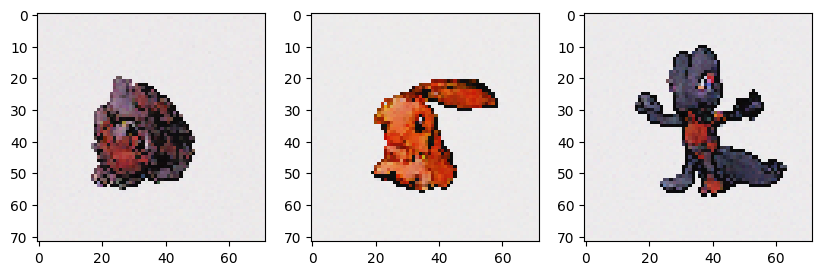

0.01708578:  96%|█████████▌| 96000/100001 [2:34:11<06:18, 10.58it/s]

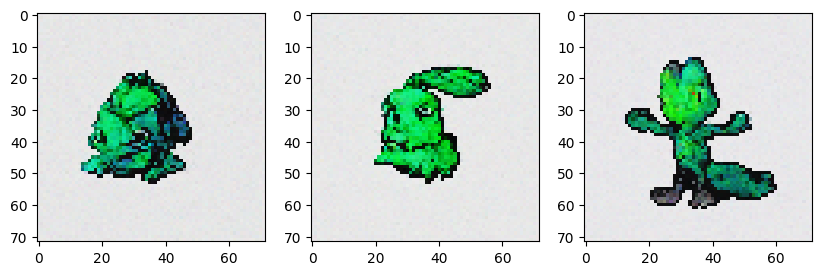

0.01508474:  97%|█████████▋| 97000/100001 [2:35:47<04:43, 10.57it/s]

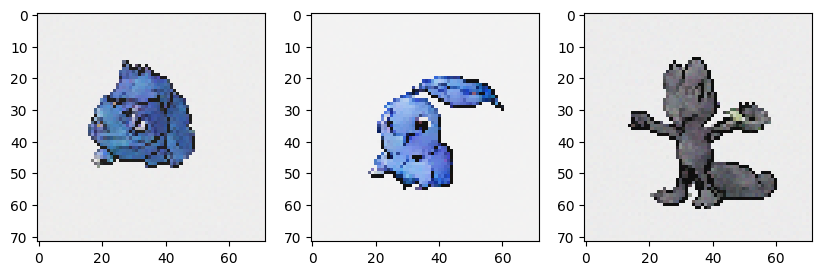

0.01362207:  98%|█████████▊| 98000/100001 [2:37:24<03:08, 10.59it/s]

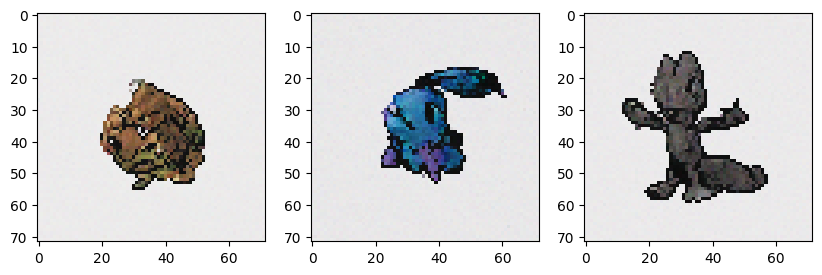

0.00932890:  99%|█████████▉| 99000/100001 [2:39:00<01:34, 10.58it/s]

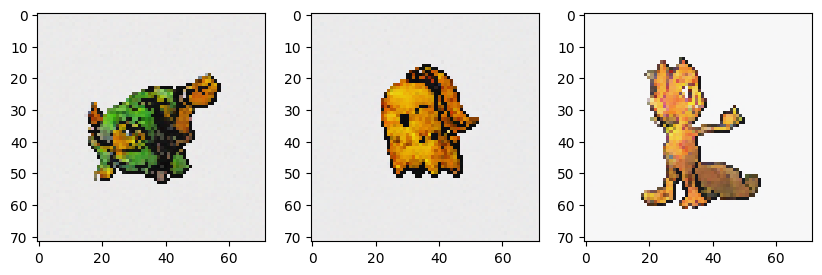

0.00485526: 100%|█████████▉| 100000/100001 [2:40:37<00:00, 10.57it/s]

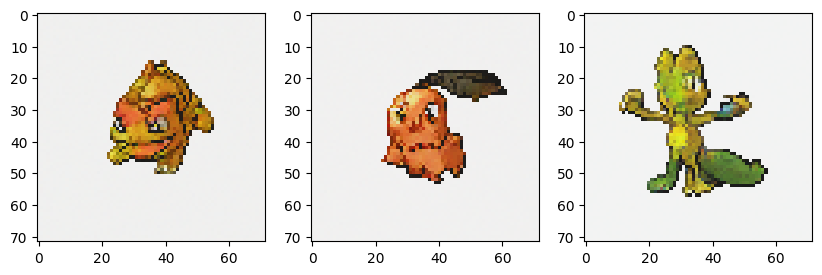

0.01723990: 100%|██████████| 100001/100001 [2:40:39<00:00, 10.37it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]
    
    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    xc = isigmoid(xc)

    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')